<a href="https://colab.research.google.com/github/saniyaverma/Crop-Disease-Prediction-Models-analysis/blob/v1/Tomato_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import os
import json
from zipfile import ZipFile
import shutil
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
import matplotlib.pyplot as plt

import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)  # suppress warnings
import random

In [2]:
SEED = 123

tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [3]:
# Load Kaggle credentials and download dataset
kaggle_credentials = json.load(open("kaggle.json"))
os.environ['KAGGLE_USERNAME'] = kaggle_credentials["username"]
os.environ['KAGGLE_KEY'] = kaggle_credentials["key"]

!kaggle datasets download -d kaustubhb999/tomatoleaf

# Unzip
with ZipFile("tomatoleaf.zip", 'r') as zip_ref:
    zip_ref.extractall()

Dataset URL: https://www.kaggle.com/datasets/kaustubhb999/tomatoleaf
License(s): CC0-1.0
tomatoleaf.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
# Paths from the dataset
train_path = "/content/tomato/train"
val_path = "/content/tomato/val"

**Create a unified folder**

In [5]:
# New unified folder
combined_path = "/content/tomato-leaf-disease"
os.makedirs(combined_path, exist_ok=True)

def combine_folders(source_dir, target_dir):
    for cls in os.listdir(source_dir):
        src_cls_path = os.path.join(source_dir, cls)
        dst_cls_path = os.path.join(target_dir, cls)
        os.makedirs(dst_cls_path, exist_ok=True)

        for file_name in os.listdir(src_cls_path):
            src_file = os.path.join(src_cls_path, file_name)
            dst_file = os.path.join(dst_cls_path, file_name)

            # Only copy if file doesn't already exist
            if not os.path.exists(dst_file):
                shutil.copy2(src_file, dst_file)

        print(f"Copied: {cls} from {source_dir} to {target_dir}")

# Combine all splits into one
combine_folders(train_path, combined_path)
combine_folders(val_path, combined_path)

Copied: Tomato___Late_blight from /content/tomato/train to /content/tomato-leaf-disease
Copied: Tomato___Leaf_Mold from /content/tomato/train to /content/tomato-leaf-disease
Copied: Tomato___Tomato_mosaic_virus from /content/tomato/train to /content/tomato-leaf-disease
Copied: Tomato___Target_Spot from /content/tomato/train to /content/tomato-leaf-disease
Copied: Tomato___Spider_mites Two-spotted_spider_mite from /content/tomato/train to /content/tomato-leaf-disease
Copied: Tomato___Tomato_Yellow_Leaf_Curl_Virus from /content/tomato/train to /content/tomato-leaf-disease
Copied: Tomato___healthy from /content/tomato/train to /content/tomato-leaf-disease
Copied: Tomato___Early_blight from /content/tomato/train to /content/tomato-leaf-disease
Copied: Tomato___Bacterial_spot from /content/tomato/train to /content/tomato-leaf-disease
Copied: Tomato___Septoria_leaf_spot from /content/tomato/train to /content/tomato-leaf-disease
Copied: Tomato___Late_blight from /content/tomato/val to /conten

**Check for total image count**

In [6]:
def count_images_in_folders(folder_path):
    total_images = 0
    print(f"\nChecking folder: {folder_path}")
    for cls in sorted(os.listdir(folder_path)):
        cls_path = os.path.join(folder_path, cls)
        if os.path.isdir(cls_path):
            count = len(os.listdir(cls_path))
            total_images += count
            print(f"{cls}: {count} images")
    print(f"\nTotal images: {total_images}")

# Run this:
count_images_in_folders("/content/tomato-leaf-disease")


Checking folder: /content/tomato-leaf-disease
Tomato___Bacterial_spot: 1100 images
Tomato___Early_blight: 1100 images
Tomato___Late_blight: 1100 images
Tomato___Leaf_Mold: 1100 images
Tomato___Septoria_leaf_spot: 1100 images
Tomato___Spider_mites Two-spotted_spider_mite: 1100 images
Tomato___Target_Spot: 1100 images
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 1100 images
Tomato___Tomato_mosaic_virus: 1100 images
Tomato___healthy: 1100 images

Total images: 11000


**Check for Corrupt or Unreadable Images**

In [7]:
def check_image_integrity(folder_path):
    broken = []
    for cls in os.listdir(folder_path):
        cls_path = os.path.join(folder_path, cls)
        for img_file in os.listdir(cls_path):
            try:
                img_path = os.path.join(cls_path, img_file)
                with Image.open(img_path) as img:
                    img.verify()
            except Exception as e:
                broken.append(img_path)
                print(f"Corrupt: {img_path} — {e}")
    if not broken:
        print("All images verified successfully.")
    else:
        print(f"Found {len(broken)} corrupt images.")

check_image_integrity("/content/tomato-leaf-disease")


All images verified successfully.


**Import data into tensorflow dataset object**

In [8]:
IMAGE_SIZE = 224
BATCH_SIZE = 16

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    combined_path,
    seed=SEED,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="int"
)

class_names = dataset.class_names
NUM_CLASSES = len(class_names)

Found 11000 files belonging to 10 classes.


**Splitting the dataset**

In [9]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)
    if shuffle:
      ds = ds.shuffle(shuffle_size, seed=123)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [10]:
len(train_ds)

550

In [11]:
len(val_ds)

68

In [12]:
len(test_ds)

70

**Preprocessing the Data**

In [14]:
resize_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255)
])

augment = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
])

AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, training=False):
    ds = ds.map(lambda x, y: (resize_rescale(x), y), num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.map(lambda x, y: (augment(x), y), num_parallel_calls=AUTOTUNE)
    return ds.prefetch(buffer_size=AUTOTUNE)

train_ds = prepare(train_ds, training=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

In [19]:
from tensorflow.keras.applications import VGG16

base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), weights='imagenet', include_top=False)

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

x = layers.Flatten()(base_model.output)
x = layers.Dropout(0.2)(x)
output = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = keras.Model(inputs = base_model.input, outputs=output)

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │       250,890 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,965,578 (57.09 MB)

 Trainable params: 250,890 (980.04 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [20]:
EPOCHS = 30

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)


Epoch 1/30
550/550 ━━━━━━━━━━━━━━━━━━━━ 110s 159ms/step - accuracy: 0.4515 - loss: 1.6539 - val_accuracy: 0.7362 - val_loss: 0.8625
Epoch 2/30
550/550 ━━━━━━━━━━━━━━━━━━━━ 125s 151ms/step - accuracy: 0.7410 - loss: 0.8344 - val_accuracy: 0.8153 - val_loss: 0.6374
Epoch 3/30
550/550 ━━━━━━━━━━━━━━━━━━━━ 167s 197ms/step - accuracy: 0.7909 - loss: 0.6611 - val_accuracy: 0.8226 - val_loss: 0.5624
Epoch 4/30
550/550 ━━━━━━━━━━━━━━━━━━━━ 111s 142ms/step - accuracy: 0.8194 - loss: 0.5706 - val_accuracy: 0.8373 - val_loss: 0.4896
Epoch 5/30
550/550 ━━━━━━━━━━━━━━━━━━━━ 142s 142ms/step - accuracy: 0.8350 - loss: 0.5238 - val_accuracy: 0.8502 - val_loss: 0.4618
Epoch 6/30
550/550 ━━━━━━━━━━━━━━━━━━━━ 87s 142ms/step - accuracy: 0.8542 - loss: 0.4669 - val_accuracy: 0.8971 - val_loss: 0.3886
Epoch 7/30
550/550 ━━━━━━━━━━━━━━━━━━━━ 91s 151ms/step - accuracy: 0.8610 - loss: 0.4421 - val_accuracy: 0.8713 - val_loss: 0.4267
Epoch 8/30
550/550 ━━━━━━━━━━━━━━━━━━━━ 87s 142ms/step - accuracy: 0.8787 - lo

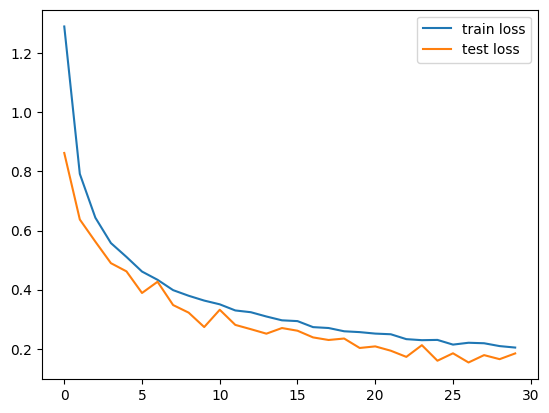

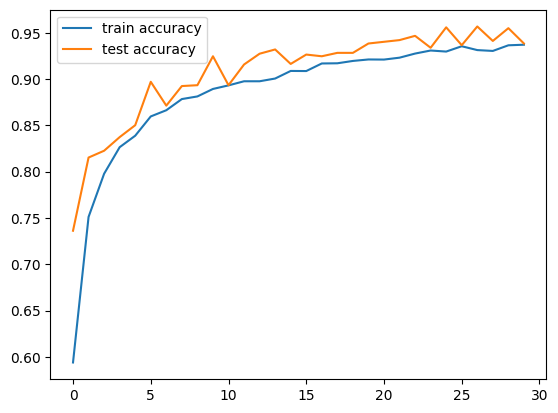

<Figure size 640x480 with 0 Axes>

In [21]:
# plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.legend()
plt.show()
plt.savefig('Loss over Epochs')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='test accuracy')
plt.legend()
plt.show()
plt.savefig('Accuracy over Epochs')

first image to print
first image actual label: Tomato___Leaf_Mold
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
predicted label Tomato___Leaf_Mold


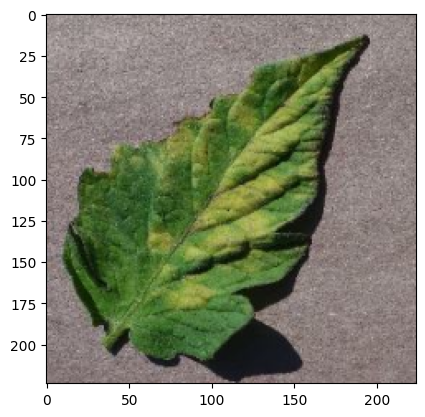

In [35]:
for image_batch,label_batch in test_ds.take(1):
    first_image = (image_batch[0].numpy() * 255).astype('uint8')
    first_label = label_batch[0].numpy()
    print("first image to print")
    plt.imshow(first_image)
    print("first image actual label:",class_names[first_label])
    batch_prediction = model.predict(image_batch)
    print("predicted label",class_names[np.argmax(batch_prediction[0])])

In [36]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img, )
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


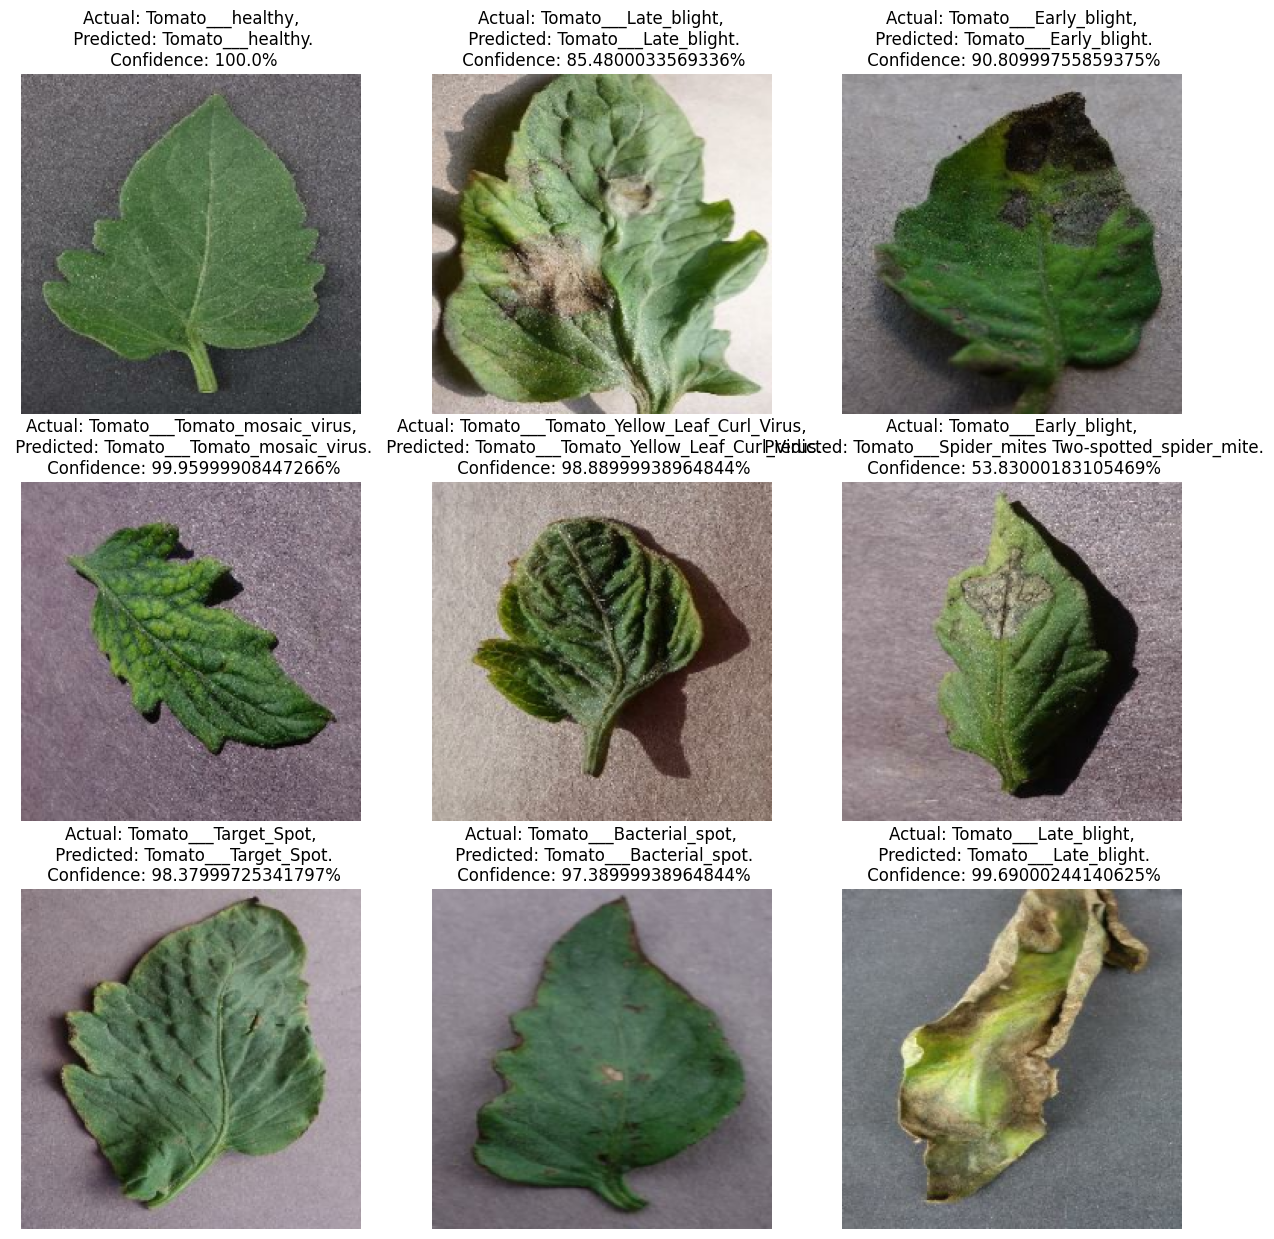

In [37]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)

        plt.imshow((images[i].numpy() * 255).astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [38]:
y_true = []
y_pred = []
y_prob = []

for images, labels in val_ds:
    preds = model.predict(images)
    preds_classes = np.argmax(preds, axis=1)  # shape (batch_size,)
    true_classes = labels.numpy()             # shape (batch_size,)


    y_true.extend(true_classes)
    y_pred.extend(preds_classes)
    y_prob.extend(preds)

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

**Accuracy**

In [39]:
acc = accuracy_score(y_true, y_pred)
print(f"Accuracy: {acc * 100:.2f}%")

Accuracy: 94.85%


**Precision**

In [40]:
precision = precision_score(y_true, y_pred, average='weighted')  # or 'macro', 'micro'
print(f"Precision: {precision * 100:.2f}%")

Precision: 95.33%


**Recall**

In [41]:
recall = recall_score(y_true, y_pred, average='weighted')
print(f"Recall: {recall * 100:.2f}%")

Recall: 94.85%


**F1 Score**

In [42]:
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"f1: {f1 * 100:.2f}%")

f1: 94.89%


**Confusion Matrix**

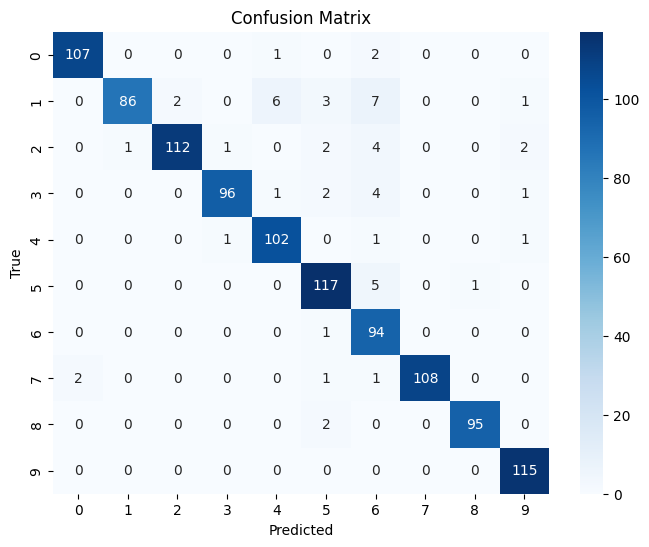

In [43]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


**AUROC**

In [44]:
from sklearn.metrics import roc_auc_score

try:
    auc_score = roc_auc_score(y_true, y_prob, multi_class='ovr', average='macro') * 100
    print(f"Macro-Averaged ROC-AUC Score: {auc_score:.2f}%")
except Exception as e:
    print("ROC AUC not available:", e)

Macro-Averaged ROC-AUC Score: 99.86%


In [45]:
model.save('tomato-leaf-disease_VGG16_model.keras')

print("Model saved successfully!")

Model saved successfully!
